In [1]:
import pdb
from pdb import set_trace as bp
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [69]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocess
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn import covariance as cov
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pyRMT as rmt
import seaborn as sns

In [3]:
from skorch import NeuralNetClassifier
# from skorch.classifier import NeuralNetBinaryClassifier, CVSplit
from skorch.callbacks import EpochScoring

In [4]:
# from sklearn.datasets import fetch_openml
data_dir = '/media/l7/data_storage1/datasets'

In [5]:
data = np.load(data_dir + '/numpy_fashion_mnist_data.npy', allow_pickle=True)
data.shape

(70000, 784)

In [6]:
target = np.load(data_dir + '/numpy_fashion_mnist_target.npy', allow_pickle=True)
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
target.shape

(70000,)

In [7]:
target = np.array(target, dtype=int)

In [8]:
def plot_numpy_images(images,targets, img_shape=[28,28], n_rows=1):
#     bp()
    plt.figure(figsize=(10,10))
    for index, img, label in zip(np.arange(images.shape[0]), images, targets):
        plt.subplot(n_rows, images.shape[0] // n_rows, index + 1)
        img = img.reshape(img_shape)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.Greys)
#         bp()
        plt.xlabel(classes[label])
    plt.tight_layout(w_pad=0)

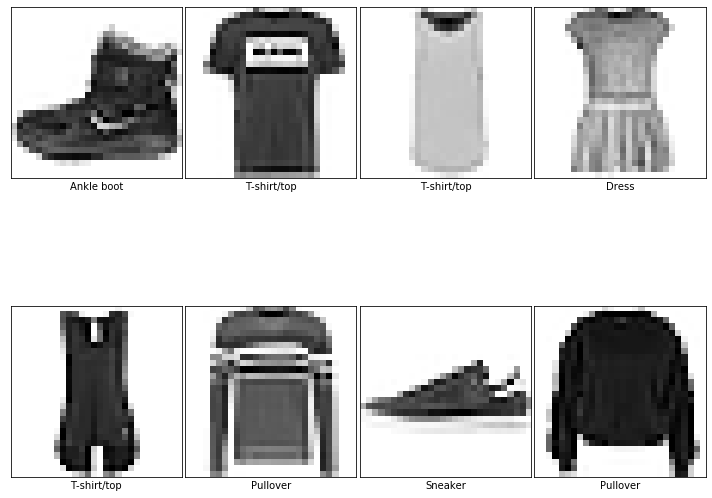

In [9]:
# Show some of the images with their respective labels. 
plot_numpy_images(data[:8],target[:8], n_rows=2)

## Processing Data

Below we are making the images range from [0,1]. Then we apply a standard scaling method, where mean is normalized over the standard deviation of the data. Finally, we visualize the resulting images. 

In [10]:
processed_data = data / 255
standard_scaler = preprocess.StandardScaler()
standard_scaler.fit(processed_data)
processed_data = standard_scaler.transform(processed_data)

In [11]:
processed_data.mean()

-2.9104027254284424e-18

In [12]:
processed_data.std()

1.0000000000000002

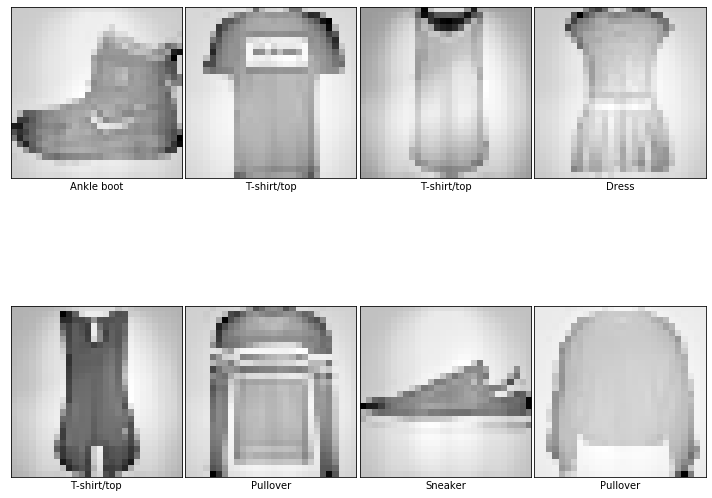

In [13]:
plot_numpy_images(processed_data[:8], target[:8], n_rows=2)

## Inspecting Different Estimators

1. First we look at the Sample Covariance Estimator, and the decorrelated output with the eigenvectors belonging the 49 highest eigenvalues. 
2. Then we consider Ledoit-Wolf Linear Shrunkage Estimator
3. Finally, we look at the output from the Rotationally Invariant Estimator. 

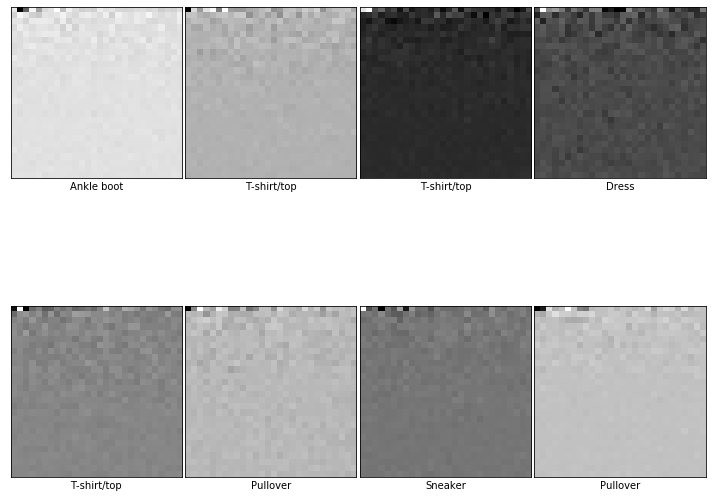

In [34]:
data_cov = np.cov(processed_data, rowvar=False)
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_sce = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_sce[:8], target[:8], img_shape=[28,28], n_rows=2)

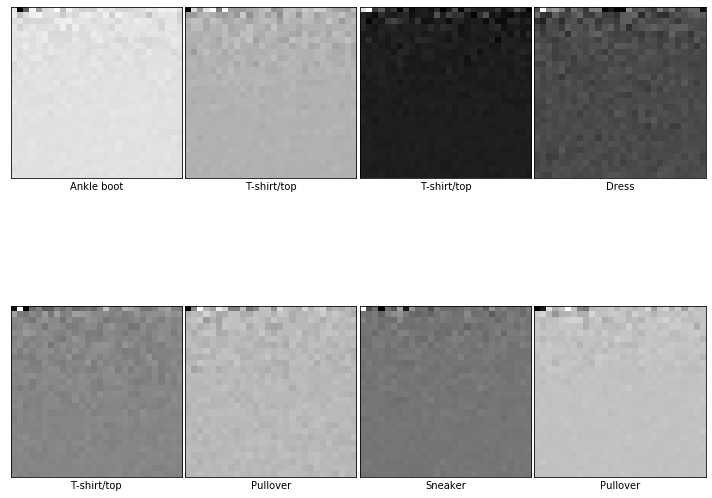

In [94]:
data_cov = cov.ledoit_wolf(processed_data, assume_centered=True)[0]
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_lwe = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_lwe[:8], target[:8], img_shape=[28,28], n_rows=2)

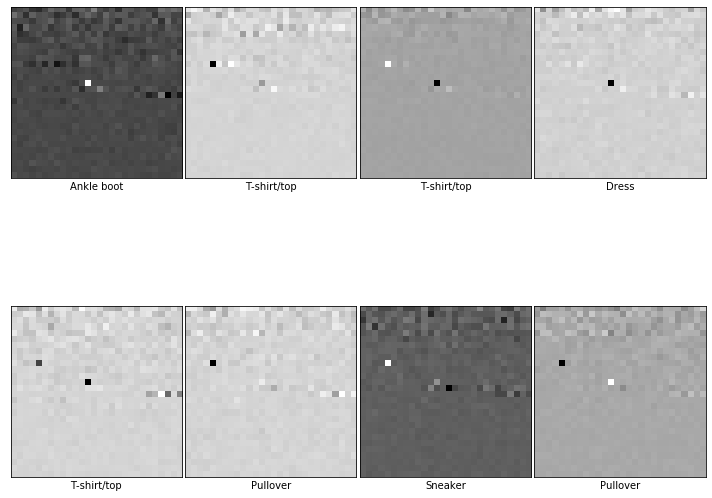

In [95]:
data_cov = rmt.optimalShrinkage(processed_data, return_covariance=True)
eigen_values, eigen_vectors = np.linalg.eig(data_cov)
decorrelated_data_rmt = processed_data.dot(eigen_vectors)
plot_numpy_images(decorrelated_data_rmt[:8], target[:8], img_shape=[28,28], n_rows=2)

In [121]:
x_train, x_test, y_train, y_test = train_test_split(processed_data, target,
                                                   test_size=0.33, random_state=42)

In [122]:
x_train = x_train.reshape([x_train.shape[0], int(np.sqrt(x_train.shape[1])),int(np.sqrt(x_train.shape[1])) ])

In [123]:
x_test = x_test.reshape([x_test.shape[0], int(np.sqrt(x_test.shape[1])),int(np.sqrt(x_test.shape[1])) ])

In [124]:
x_test.shape

(23100, 28, 28)

In [ ]:
# train_dataset = torch.utils.data.Dataset()
# train_loader = torch.utils.data.DataLoader()

In [41]:
class LeNet5(nn.Module):
    def __init__(self, n_channels, n_features):
        super(LeNet5, self).__init__()
        self.conv2d_1 = nn.Conv2d(1, 16, 5)
        self.name = 'LeNet5'
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2d_2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
#         bp()
        x = self.max_pool(self.relu(self.conv2d_1(x))) # [50, 16, 1, 1]
        # bp()
        x = self.max_pool(self.relu(self.conv2d_2(x)))
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [125]:
x_train = torch.tensor(x_train).float().unsqueeze(1)
y_train = torch.tensor(y_train).long()


In [126]:
x_test = torch.tensor(x_test).float().unsqueeze(1)
y_test = torch.tensor(y_test).long()


In [127]:
device = torch.device('cuda')
model_name = LeNet5.__name__
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
net = LeNet5(n_channels, n_features)
net.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    #bp()
    input_data = torch.tensor(x_train[:50]).float()
    labels = torch.tensor(y_train[:50]).long()
    input_data = input_data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', input_data.shape)
    y = net(input_data)
    loss = criterion(y, labels)
    print('loss: {}'.format(loss))
#     assert y.shape == torch.Size([y_train.shape[0], 10]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')


Shape of the input tensor: torch.Size([50, 1, 28, 28])
loss: 2.3088321685791016
The shapes seem to be ok.


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [128]:
model = None
n_epochs = 10
model = NeuralNetClassifier(module=LeNet5, 
                            criterion=nn.CrossEntropyLoss,
                            module__n_channels= n_channels,
                            module__n_features=n_features,
                            optimizer=optim.Adam, 
                            optimizer__lr=0.001,
                            max_epochs=n_epochs, 
                            batch_size=32,
                            iterator_train__shuffle=True,
                            device=device,
                            warm_start=True,#train_split=None,
                           )


In [129]:
model.fit(x_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5638       0.8489        0.4138  2.7026
      2        0.3542       0.8700        0.3534  2.6711
      3        0.3020       0.8835        0.3262  2.8753
      4        0.2679       0.8920        0.3046  2.6295
      5        0.2410       0.8958        0.3018  2.7232
      6        0.2181       0.8968        0.2979  2.6388
      7        0.1991       0.8942        0.3093  2.5919
      8        0.1804       0.8925        0.3187  2.6298
      9        0.1659       0.8959        0.3195  2.7056
     10        0.1496       0.8981        0.3371  2.6527


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LeNet5(
    (conv2d_1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu): ReLU()
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=512, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  ),
)

In [130]:
def plot_confusion_matrix(y_pred, y, prefix_information='',
                          dataset_name='', save_results=False,
                          y_pred_is_predicted_classes=False):
    """
    PLotting confusion matrix of different datasets (train, test, and validation).
    :param y_pred:
    :param y:
    :param prefix_information:
    :param dataset_name:
    :param save_results:
    :param y_pred_is_predicted_classes:
    :return:
    """
    if 'Tensor' in str(type(y)):
        y = y.numpy()
#     bp()
    # _, predicted = torch.max(torch.tensor(y_pred), 1)
#     y_pred = predicted
    
    c_matrix = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    result_accuracy_string = "Accuracy of Net: {:.2f}".format(accuracy)
    print(result_accuracy_string)
    print("\nClassification report:")
    classfication_report_string = classification_report(y, y_pred)
    print(classfication_report_string)
#     plt.figure(figsize=(10,10))
    # plt.title('blah')
    fig, ax = plt.subplots(1, figsize=(10, 10))
    #ax.set_title(dataset_name + " Confusion matrix")
    ax.set_title(" Confusion matrix")
    sns.heatmap(c_matrix, cmap='Blues', 
                annot=True, xticklabels=classes, 
                yticklabels=classes, fmt='g', cbar=False)
    ax.set_xlabel('predictions')
    ax.set_ylabel('true labels')
    plt.tight_layout(pad=1.08, w_pad=10, h_pad=10)
    # plt.show()
    return accuracy
    

Accuracy of Net: 0.90

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2299
           1       0.98      0.97      0.98      2345
           2       0.84      0.86      0.85      2287
           3       0.89      0.91      0.90      2342
           4       0.89      0.78      0.83      2289
           5       0.94      0.98      0.96      2348
           6       0.73      0.76      0.74      2325
           7       0.92      0.96      0.94      2287
           8       0.96      0.98      0.97      2224
           9       0.98      0.92      0.95      2354

   micro avg       0.90      0.90      0.90     23100
   macro avg       0.90      0.90      0.90     23100
weighted avg       0.90      0.90      0.90     23100



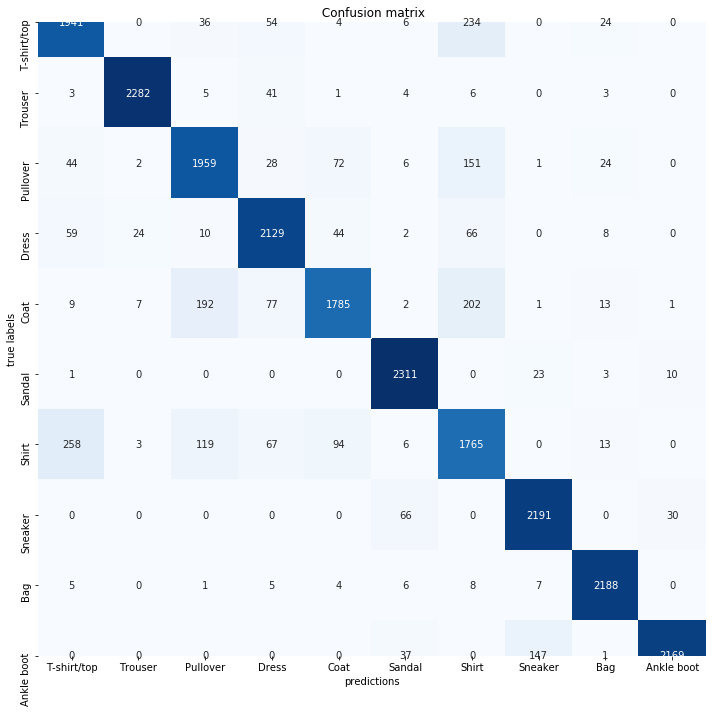

In [131]:
pred_test = model.predict(x_test)
accuracy = plot_confusion_matrix(pred_test, y_test, )